### Import libraries

In [1]:
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

### Load the dataset

In [2]:
data = pd.read_csv("/Users/veda/Downloads/IOT-temp.csv")
print(data.shape)
data.head(3)

(97606, 5)


id  room_id/id        noted_date  temp  \
0  __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29   
1  __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30    29   
2  __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41   

  out/in  
0     In  
1     In  
2    Out

### Pre-processing

In [4]:
data['room_id/id'].value_counts()

Room Admin    97606
Name: room_id/id, dtype: int64

In [5]:
data.drop('room_id/id', axis=1, inplace=True)
data.head(3)

id        noted_date  temp out/in
0  __export__.temp_log_196134_bd201015  08-12-2018 09:30    29     In
1  __export__.temp_log_196131_7bca51bc  08-12-2018 09:30    29     In
2  __export__.temp_log_196127_522915e3  08-12-2018 09:29    41    Out

In [6]:
data.rename(columns={'noted_date':'date', 'out/in':'place'}, inplace=True)
data.head(3)

id              date  temp place
0  __export__.temp_log_196134_bd201015  08-12-2018 09:30    29    In
1  __export__.temp_log_196131_7bca51bc  08-12-2018 09:30    29    In
2  __export__.temp_log_196127_522915e3  08-12-2018 09:29    41   Out

In [7]:
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y %H:%M')
data['year'] = data['date'].apply(lambda x : x.year)
data['month'] = data['date'].apply(lambda x : x.month)
data['day'] = data['date'].apply(lambda x : x.day)
data['weekday'] = data['date'].apply(lambda x : x.day_name())
data['weekofyear'] = data['date'].apply(lambda x : x.weekofyear)
data['hour'] = data['date'].apply(lambda x : x.hour)
data['minute'] = data['date'].apply(lambda x : x.minute)
data.head(3)

id                date  temp place  year  \
0  __export__.temp_log_196134_bd201015 2018-12-08 09:30:00    29    In  2018   
1  __export__.temp_log_196131_7bca51bc 2018-12-08 09:30:00    29    In  2018   
2  __export__.temp_log_196127_522915e3 2018-12-08 09:29:00    41   Out  2018   

   month  day   weekday  weekofyear  hour  minute  
0     12    8  Saturday          49     9      30  
1     12    8  Saturday          49     9      30  
2     12    8  Saturday          49     9      29

In [8]:
def month2seasons(x):
    if x in [12, 1, 2]:
        season = 'Winter'
    elif x in [3, 4, 5]:
        season = 'Summer'
    elif x in [6, 7, 8, 9]:
        season = 'Monsoon'
    elif x in [10, 11]:
        season = 'Post_Monsoon'
    return season

In [9]:
data['season'] = data['month'].apply(month2seasons)
data.head(3)

id                date  temp place  year  \
0  __export__.temp_log_196134_bd201015 2018-12-08 09:30:00    29    In  2018   
1  __export__.temp_log_196131_7bca51bc 2018-12-08 09:30:00    29    In  2018   
2  __export__.temp_log_196127_522915e3 2018-12-08 09:29:00    41   Out  2018   

   month  day   weekday  weekofyear  hour  minute  season  
0     12    8  Saturday          49     9      30  Winter  
1     12    8  Saturday          49     9      30  Winter  
2     12    8  Saturday          49     9      29  Winter

In [10]:
def hours2timing(x):
    if x in [22,23,0,1,2,3]:
        timing = 'Night'
    elif x in range(4, 12):
        timing = 'Morning'
    elif x in range(12, 17):
        timing = 'Afternoon'
    elif x in range(17, 22):
        timing = 'Evening'
    else:
        timing = 'X'
    return timing

In [11]:
data['timing'] = data['hour'].apply(hours2timing)
data.head(3)

id                date  temp place  year  \
0  __export__.temp_log_196134_bd201015 2018-12-08 09:30:00    29    In  2018   
1  __export__.temp_log_196131_7bca51bc 2018-12-08 09:30:00    29    In  2018   
2  __export__.temp_log_196127_522915e3 2018-12-08 09:29:00    41   Out  2018   

   month  day   weekday  weekofyear  hour  minute  season   timing  
0     12    8  Saturday          49     9      30  Winter  Morning  
1     12    8  Saturday          49     9      30  Winter  Morning  
2     12    8  Saturday          49     9      29  Winter  Morning

In [12]:
data[data.duplicated()]

id                date  temp place  year  \
11  __export__.temp_log_196108_4a983c7e 2018-12-08 09:25:00    42   Out  2018   

    month  day   weekday  weekofyear  hour  minute  season   timing  
11     12    8  Saturday          49     9      25  Winter  Morning

In [13]:
data[data['id']=='__export__.temp_log_196108_4a983c7e']

id                date  temp place  year  \
10  __export__.temp_log_196108_4a983c7e 2018-12-08 09:25:00    42   Out  2018   
11  __export__.temp_log_196108_4a983c7e 2018-12-08 09:25:00    42   Out  2018   

    month  day   weekday  weekofyear  hour  minute  season   timing  
10     12    8  Saturday          49     9      25  Winter  Morning  
11     12    8  Saturday          49     9      25  Winter  Morning

In [14]:
data.drop_duplicates(inplace=True)
data[data.duplicated()]

Empty DataFrame
Columns: [id, date, temp, place, year, month, day, weekday, weekofyear, hour, minute, season, timing]
Index: []

In [15]:
data.loc[data['date']=='2018-09-12 03:09:00', ].sort_values(by='id').head(5)

id                date  temp place  \
61229  __export__.temp_log_101144_ff2f0b97 2018-09-12 03:09:00    29   Out   
61258  __export__.temp_log_101502_172517d2 2018-09-12 03:09:00    29    In   
61255  __export__.temp_log_104868_a5e526b3 2018-09-12 03:09:00    28    In   
61231  __export__.temp_log_108845_062b2592 2018-09-12 03:09:00    28    In   
61272  __export__.temp_log_112303_fca608f4 2018-09-12 03:09:00    29    In   

       year  month  day    weekday  weekofyear  hour  minute   season timing  
61229  2018      9   12  Wednesday          37     3       9  Monsoon  Night  
61258  2018      9   12  Wednesday          37     3       9  Monsoon  Night  
61255  2018      9   12  Wednesday          37     3       9  Monsoon  Night  
61231  2018      9   12  Wednesday          37     3       9  Monsoon  Night  
61272  2018      9   12  Wednesday          37     3       9  Monsoon  Night

In [16]:
data['id'].apply(lambda x : x.split('_')[6]).nunique() == len(df)

True

In [17]:
data['id'] = data['id'].apply(lambda x : int(x.split('_')[6]))
data.head(3)

id                date  temp place  year  month  day   weekday  \
0  196134 2018-12-08 09:30:00    29    In  2018     12    8  Saturday   
1  196131 2018-12-08 09:30:00    29    In  2018     12    8  Saturday   
2  196127 2018-12-08 09:29:00    41   Out  2018     12    8  Saturday   

   weekofyear  hour  minute  season   timing  
0          49     9      30  Winter  Morning  
1          49     9      30  Winter  Morning  
2          49     9      29  Winter  Morning

In [18]:
data.loc[df['date'] == '2018-09-12 03:09:00', ].sort_values(by ='id').head(5)

id                date  temp place  year  month  day    weekday  \
61273  17002 2018-09-12 03:09:00    29   Out  2018      9   12  Wednesday   
61275  17003 2018-09-12 03:09:00    28   Out  2018      9   12  Wednesday   
61267  17006 2018-09-12 03:09:00    28   Out  2018      9   12  Wednesday   
61269  17009 2018-09-12 03:09:00    28   Out  2018      9   12  Wednesday   
61271  17010 2018-09-12 03:09:00    29   Out  2018      9   12  Wednesday   

       weekofyear  hour  minute   season timing  
61273          37     3       9  Monsoon  Night  
61275          37     3       9  Monsoon  Night  
61267          37     3       9  Monsoon  Night  
61269          37     3       9  Monsoon  Night  
61271          37     3       9  Monsoon  Night

In [19]:
data.loc[data['id'].isin(range(4000, 4011))].sort_values(by='id')

id                date  temp place  year  month  day weekday  \
84141  4000 2018-09-09 16:24:00    29   Out  2018      9    9  Sunday   
84142  4002 2018-09-09 16:24:00    29   Out  2018      9    9  Sunday   
84144  4004 2018-09-09 16:23:00    28   Out  2018      9    9  Sunday   
84128  4006 2018-09-09 16:24:00    28   Out  2018      9    9  Sunday   
84132  4007 2018-09-09 16:24:00    29   Out  2018      9    9  Sunday   
84136  4009 2018-09-09 16:24:00    28   Out  2018      9    9  Sunday   
84137  4010 2018-09-09 16:24:00    28   Out  2018      9    9  Sunday   

       weekofyear  hour  minute   season     timing  
84141          36    16      24  Monsoon  Afternoon  
84142          36    16      24  Monsoon  Afternoon  
84144          36    16      23  Monsoon  Afternoon  
84128          36    16      24  Monsoon  Afternoon  
84132          36    16      24  Monsoon  Afternoon  
84136          36    16      24  Monsoon  Afternoon  
84137          36    16      24  Monsoon  Afternoon

### Monthly Readings

In [20]:
month_rd = np.round(data['date'].apply(lambda x : x.strftime("%Y-%m")).value_counts(normalize=True).sort_index() * 100,decimals=1)
month_rd_bar = hv.Bars(month_rd).opts(color="green")
month_rd_curve = hv.Curve(month_rd).opts(color="red")
(month_rd_bar * month_rd_curve).opts(title="Monthly Readings Count", xlabel="Month", ylabel="Percentage", yformatter='%d%%', width=700, height=300,tools=['hover'],show_grid=True)

:Overlay
   .Bars.I  :Bars   [index]   (date)
   .Curve.I :Curve   [index]   (date)

In [21]:
hv.Distribution(df['temp']).opts(title="Temperature Distribution", color="green", xlabel="Temperature", ylabel="Density").opts(opts.Distribution(width=700, height=300,tools=['hover'],show_grid=True))

:Distribution   [temp]   (Density)

### Place

In [22]:
pl_cnt = np.round(data['place'].value_counts(normalize=True) * 100)
hv.Bars(pl_cnt).opts(title="Readings Place Count", color="green", xlabel="Places", ylabel="Percentage", yformatter='%d%%').opts(opts.Bars(width=700, height=300,tools=['hover'],show_grid=True))

:Bars   [index]   (place)

### Season

In [23]:
season_cnt = np.round(data['season'].value_counts(normalize=True) * 100)
hv.Bars(season_cnt).opts(title="Season Count", color="green", xlabel="Season", ylabel="Percentage", yformatter='%d%%').opts(opts.Bars(width=700, height=300,tools=['hover'],show_grid=True))

:Bars   [index]   (season)

### Timing

In [24]:
timing_cnt = np.round(data['timing'].value_counts(normalize=True) * 100)
hv.Bars(timing_cnt).opts(title="Timing Count", color="green", xlabel="Timing", ylabel="Percentage", yformatter='%d%%').opts(opts.Bars(width=700, height=300,tools=['hover'],show_grid=True))

:Bars   [index]   (timing)

### Monthly Readings by Place

In [25]:
in_month = np.round(data[data['place']=='In']['date'].apply(lambda x : x.strftime("%Y-%m")).value_counts(normalize=True).sort_index() * 100, decimals=1)
out_month = np.round(data[data['place']=='Out']['date'].apply(lambda x : x.strftime("%Y-%m")).value_counts(normalize=True).sort_index() * 100, decimals=1)
in_out_month = pd.merge(in_month,out_month,right_index=True,left_index=True).rename(columns={'date_x':'In', 'date_y':'Out'})
in_out_month = pd.melt(in_out_month.reset_index(), ['index']).rename(columns={'index':'Month', 'variable':'Place'})
hv.Bars(in_out_month, ['Month', 'Place'], 'value').opts(opts.Bars(title="Monthly Readings by Place Count", width=700, height=400,tools=['hover'],show_grid=True, ylabel="Count"))

:Bars   [Month,Place]   (value)

In [26]:
(hv.Distribution(df[data['place']=='In']['temp'], label='In') * hv.Distribution(data[data['place']=='Out']['temp'], label='Out')).opts(title="Temperature by Place Distribution", xlabel="Temperature", ylabel="Density").opts(opts.Distribution(width=700, height=300,tools=['hover'],show_grid=True))

:Overlay
   .Distribution.In  :Distribution   [temp]   (Density)
   .Distribution.Out :Distribution   [temp]   (Density)

### Temperature by Season

In [27]:
season_agg = data.groupby('season').agg({'temp': ['min', 'max']})
season_maxmin = pd.merge(season_agg['temp']['max'],season_agg['temp']['min'],right_index=True,left_index=True)
season_maxmin = pd.melt(season_maxmin.reset_index(), ['season']).rename(columns={'season':'Season', 'variable':'Max/Min'})
hv.Bars(season_maxmin, ['Season', 'Max/Min'], 'value').opts(title="Temperature by Season Max/Min", ylabel="Temperature").opts(opts.Bars(width=700, height=300,tools=['hover'],show_grid=True))

:Bars   [Season,Max/Min]   (value)

### Temperature by Timing

In [28]:
timing_agg = data.groupby('timing').agg({'temp': ['min', 'max']})
timing_maxmin = pd.merge(timing_agg['temp']['max'],timing_agg['temp']['min'],right_index=True,left_index=True)
timing_maxmin = pd.melt(timing_maxmin.reset_index(), ['timing']).rename(columns={'timing':'Timing', 'variable':'Max/Min'})
hv.Bars(timing_maxmin, ['Timing', 'Max/Min'], 'value').opts(title="Temperature by Timing Max/Min", ylabel="Temperature").opts(opts.Bars(width=700, height=300,tools=['hover'],show_grid=True))

:Bars   [Timing,Max/Min]   (value)

## Time Series Analysis

In [29]:
tsdf = data.drop_duplicates(subset=['date','place']).sort_values('date').reset_index(drop=True)
tsdf['temp'] = data.groupby(['date','place'])['temp'].mean().values
tsdf.drop('id', axis=1, inplace=True)
tsdf.head(3)

date  temp place  year  month  day   weekday  weekofyear  \
0 2018-07-28 07:06:00  31.0    In  2018      7   28  Saturday          30   
1 2018-07-28 07:07:00  31.0   Out  2018      7   28  Saturday          30   
2 2018-07-28 07:07:00  32.0    In  2018      7   28  Saturday          30   

   hour  minute   season   timing  
0     7       6  Monsoon  Morning  
1     7       7  Monsoon  Morning  
2     7       7  Monsoon  Morning

In [30]:
in_month = tsdf[tsdf['place']=='In'].groupby('month').agg({'temp':['mean']})
in_month.columns = [f"{i[0]}_{i[1]}" for i in in_month.columns]
out_month = tsdf[tsdf['place']=='Out'].groupby('month').agg({'temp':['mean']})
out_month.columns = [f"{i[0]}_{i[1]}" for i in out_month.columns]
hv.Curve(in_month, label='In') * hv.Curve(out_month, label='Out').opts(title="Monthly Temperature Mean", ylabel="Temperature", xlabel='Month')\
                                                                    .opts(opts.Curve(width=700, height=300,tools=['hover'],show_grid=True))

:Overlay
   .Curve.In  :Curve   [month]   (temp_mean)
   .Curve.Out :Curve   [month]   (temp_mean)

### Daily Temperature Mean

In [31]:
tsdf['daily'] = tsdf['date'].apply(lambda x : pd.to_datetime(x.strftime('%Y-%m-%d')))
in_day = tsdf[tsdf['place']=='In'].groupby(['daily']).agg({'temp':['mean']})
in_day.columns = [f"{i[0]}_{i[1]}" for i in in_day.columns]
out_day = tsdf[tsdf['place']=='Out'].groupby(['daily']).agg({'temp':['mean']})
out_day.columns = [f"{i[0]}_{i[1]}" for i in out_day.columns]
(hv.Curve(in_day, label='In') * hv.Curve(out_day, label='Out')).opts(title="Daily Temperature Mean", ylabel="Temperature", xlabel='Day', shared_axes=False)\
                                                                    .opts(opts.Curve(width=700, height=300,tools=['hover'],show_grid=True))

:Overlay
   .Curve.In  :Curve   [daily]   (temp_mean)
   .Curve.Out :Curve   [daily]   (temp_mean)

### Weekday Temperature Mean

In [32]:
in_wd = tsdf[tsdf['place']=='In'].groupby('weekday').agg({'temp':['mean']})
in_wd.columns = [f"{i[0]}_{i[1]}" for i in in_wd.columns]
in_wd['week_num'] = [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(i) for i in in_wd.index]
in_wd.sort_values('week_num', inplace=True)
in_wd.drop('week_num', axis=1, inplace=True)
out_wd = tsdf[tsdf['place']=='Out'].groupby('weekday').agg({'temp':['mean']})
out_wd.columns = [f"{i[0]}_{i[1]}" for i in out_wd.columns]
out_wd['week_num'] = [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(i) for i in out_wd.index]
out_wd.sort_values('week_num', inplace=True)
out_wd.drop('week_num', axis=1, inplace=True)
hv.Curve(in_wd, label='In') * hv.Curve(out_wd, label='Out').opts(title="Weekday Temperature Mean", ylabel="Temperature", xlabel='Weekday')\
                                                                    .opts(opts.Curve(width=700, height=300,tools=['hover'],show_grid=True))

:Overlay
   .Curve.In  :Curve   [weekday]   (temp_mean)
   .Curve.Out :Curve   [weekday]   (temp_mean)

### WeekofYear Temperature Mean

In [33]:
in_wof = tsdf[tsdf['place']=='In'].groupby('weekofyear').agg({'temp':['mean']})
in_wof.columns = [f"{i[0]}_{i[1]}" for i in in_wof.columns]
out_wof = tsdf[tsdf['place']=='Out'].groupby('weekofyear').agg({'temp':['mean']})
out_wof.columns = [f"{i[0]}_{i[1]}" for i in out_wof.columns]
hv.Curve(in_wof, label='In') * hv.Curve(out_wof, label='Out').opts(title="WeekofYear Temperature Mean", ylabel="Temperature", xlabel='WeekofYear')\
                                                                    .opts(opts.Curve(width=700, height=300,tools=['hover'],show_grid=True))

:Overlay
   .Curve.In  :Curve   [weekofyear]   (temp_mean)
   .Curve.Out :Curve   [weekofyear]   (temp_mean)

In [34]:
in_tsdf = tsdf[tsdf['place']=='In'].reset_index(drop=True)
in_tsdf.index = in_tsdf['date']
in_all = hv.Curve(in_tsdf['temp']).opts(title="[In] Temperature All", ylabel="Temperature", xlabel='Time', color='red')

out_tsdf = tsdf[tsdf['place']=='Out'].reset_index(drop=True)
out_tsdf.index = out_tsdf['date']
out_all = hv.Curve(out_tsdf['temp']).opts(title="[Out] Temperature All", ylabel="Temperature", xlabel='Time', color='blue')

in_tsdf_int = in_tsdf['temp'].resample('1min').interpolate(method='nearest')
in_tsdf_int_all = hv.Curve(in_tsdf_int).opts(title="[In] Temperature All Interpolated with 'nearest'", ylabel="Temperature", xlabel='Time', color='red', fontsize={'title':11})
out_tsdf_int = out_tsdf['temp'].resample('1min').interpolate(method='nearest')
out_tsdf_int_all = hv.Curve(out_tsdf_int).opts(title="[Out] Temperature All Interpolated with 'nearest'", ylabel="Temperature", xlabel='Time', color='blue', fontsize={'title':11})

(in_all + in_tsdf_int_all + out_all + out_tsdf_int_all).opts(opts.Curve(width=400, height=300,tools=['hover'],show_grid=True)).opts(shared_axes=False).cols(2)

:Layout
   .Curve.I   :Curve   [date]   (temp)
   .Curve.II  :Curve   [date]   (temp)
   .Curve.III :Curve   [date]   (temp)
   .Curve.IV  :Curve   [date]   (temp)

In [35]:
in_d_org = hv.Curve(in_day).opts(title="[In] Daily Temperature Mean", ylabel="Temperature", xlabel='Time', color='red')
out_d_org = hv.Curve(out_day).opts(title="[Out] Daily Temperature Mean", ylabel="Temperature", xlabel='Time', color='blue')

inp_df = pd.DataFrame()
in_d_inp = in_day.resample('1D').interpolate('spline', order=5)
out_d_inp = out_day.resample('1D').interpolate('spline', order=5)
inp_df['In'] = in_d_inp.temp_mean
inp_df['Out'] = out_d_inp.temp_mean

in_d_inp_g = hv.Curve(inp_df['In']).opts(title="[In] Daily Temperature Mean Interpolated with 'spline'", ylabel="Temperature", xlabel='Time', color='red', fontsize={'title':10})
out_d_inp_g = hv.Curve(inp_df['Out']).opts(title="[Out] Daily Temperature Mean Interpolated with 'spline'", ylabel="Temperature", xlabel='Time', color='blue', fontsize={'title':10})

(in_d_org + in_d_inp_g + out_d_org + out_d_inp_g).opts(opts.Curve(width=400, height=300,tools=['hover'],show_grid=True)).opts(shared_axes=False).cols(2)

:Layout
   .Curve.I   :Curve   [daily]   (temp_mean)
   .Curve.II  :Curve   [daily]   (In)
   .Curve.III :Curve   [daily]   (temp_mean)
   .Curve.IV  :Curve   [daily]   (Out)

In [36]:
org_df = inp_df.reset_index()
org_df['season'] = org_df['daily'].apply(lambda x : month2seasons(x.month))
org_df = pd.get_dummies(org_df, columns=['season'])
org_df.head(3)

daily         In        Out  season_Monsoon  season_Post_Monsoon  \
0 2018-07-28  31.142857  31.691667               1                    0   
1 2018-07-29  32.500000  31.333333               1                    0   
2 2018-07-30  31.866909  31.555176               1                    0   

   season_Winter  
0              0  
1              0  
2              0

### Model Building

In [37]:
def run_prophet(place, prediction_periods, plot_comp=True):
    # make dataframe for training
    prophet_df = pd.DataFrame()
    prophet_df["ds"] = pd.date_range(start=org_df['daily'][0], end=org_df['daily'][133])
    prophet_df['y'] = org_df[place]
    # add seasonal information
    prophet_df['monsoon'] = org_df['season_Monsoon']
    prophet_df['post_monsoon'] = org_df['season_Post_Monsoon']
    prophet_df['winter'] = org_df['season_Winter']

    # train model by Prophet
    m = Prophet(changepoint_prior_scale=0.1, yearly_seasonality=2, weekly_seasonality=False)
    # include seasonal periodicity into the model
    m.add_seasonality(name='season_monsoon', period=124, fourier_order=5, prior_scale=0.1, condition_name='monsoon')
    m.add_seasonality(name='season_post_monsoon', period=62, fourier_order=5, prior_scale=0.1, condition_name='post_monsoon')
    m.add_seasonality(name='season_winter', period=93, fourier_order=5, prior_scale=0.1, condition_name='winter')
    m.fit(prophet_df)

    # make dataframe for prediction
    future = m.make_future_dataframe(periods=prediction_periods)
    # add seasonal information
    future_season = pd.get_dummies(future['ds'].apply(lambda x : month2seasons(x.month)))
    future['monsoon'] = future_season['Monsoon']
    future['post_monsoon'] = future_season['Monsoon']
    future['winter'] = future_season['Winter']

    # predict the future temperature
    prophe_result = m.predict(future)

    # plot prediction
    fig1 = m.plot(prophe_result)
    ax = fig1.gca()
    ax.set_title(f"{place} Prediction", size=25)
    ax.set_xlabel("Time", size=15)
    ax.set_ylabel("Temperature", size=15)
    a = add_changepoints_to_plot(ax, m, prophe_result)
    fig1.show()
    # plot decomposed timse-series components
    if plot_comp:
        fig2 = m.plot_components(prophe_result)
        fig2.show()

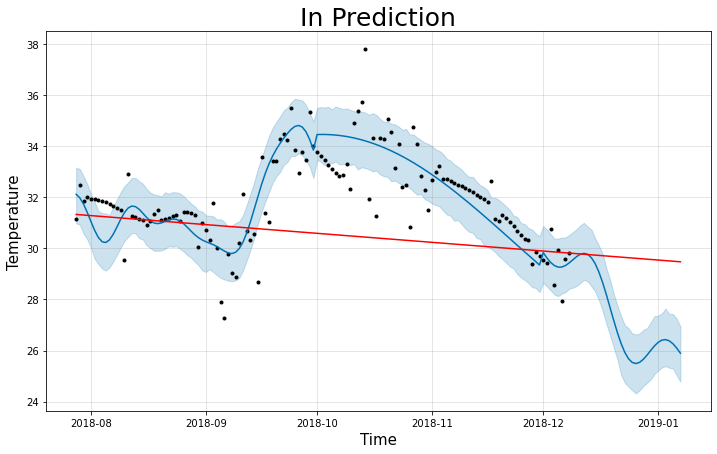

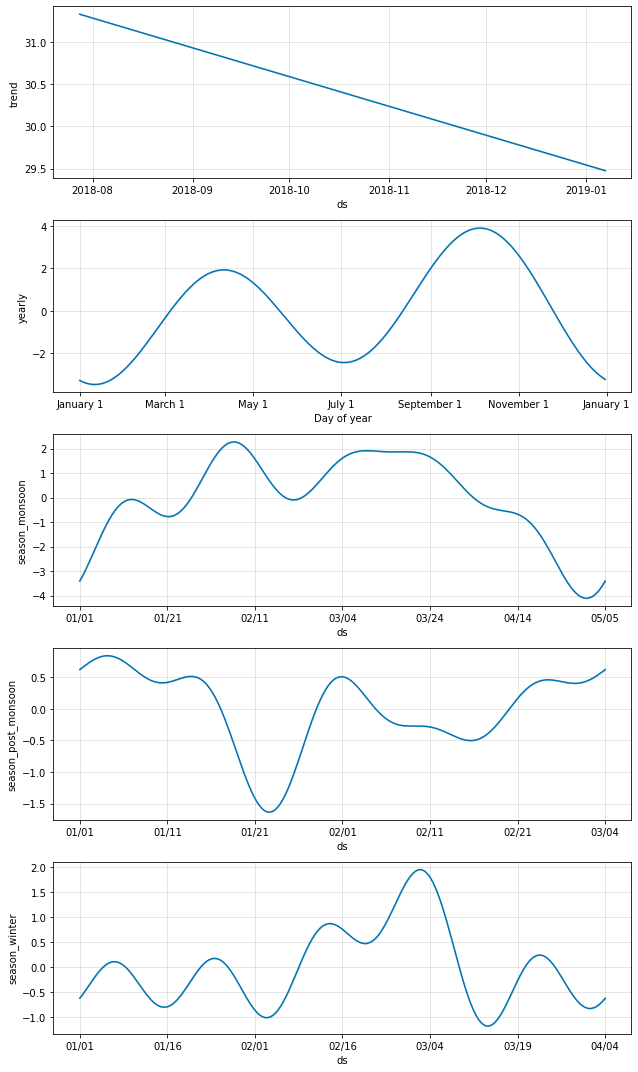

In [38]:
run_prophet('In',30)

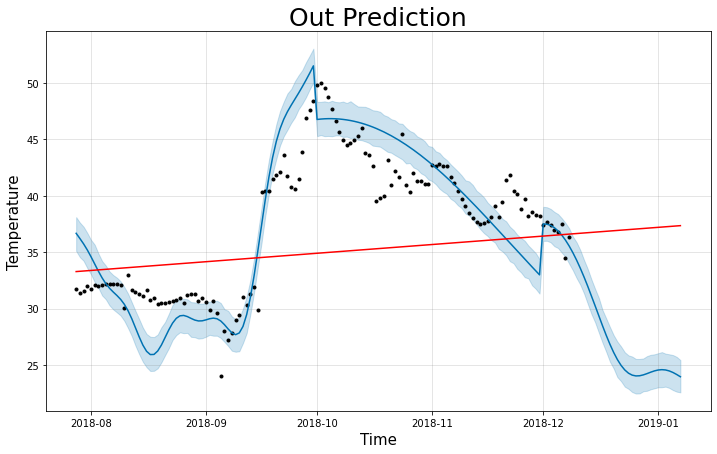

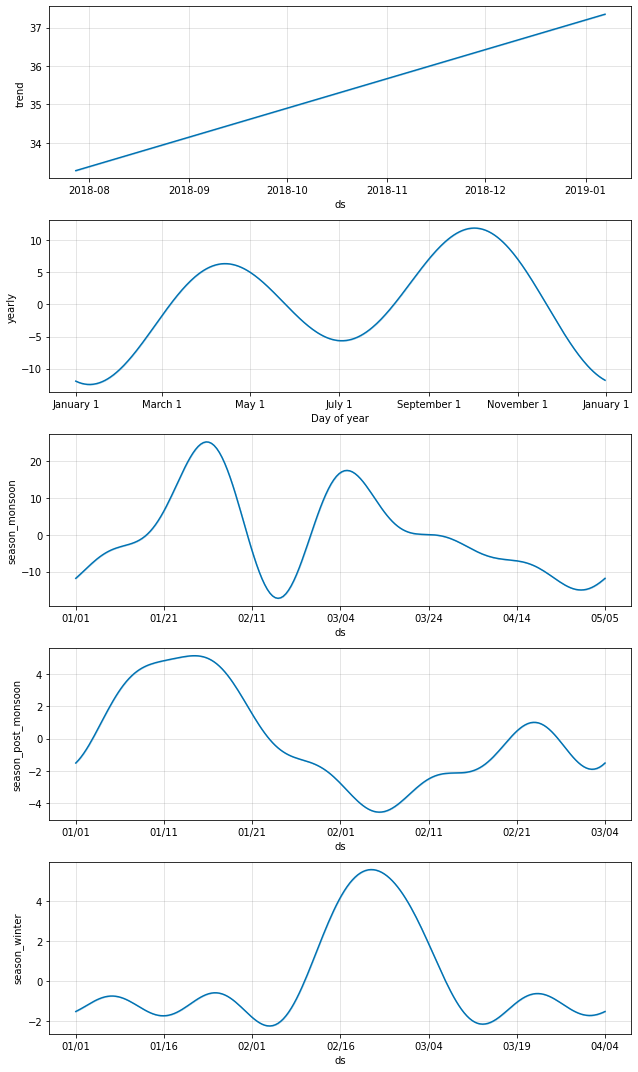

In [39]:
run_prophet('Out',30)

In [40]:
dist = (hv.Distribution(df[df['place']=='In']['temp'], label='In') * hv.Distribution(df[df['place']=='Out']['temp'], label='Out'))\
                                .opts(title="Temperature by Place Distribution", xlabel="Temperature", ylabel="Density",tools=['hover'],show_grid=True, fontsize={'title':11})
tsdf['daily'] = tsdf['date'].apply(lambda x : pd.to_datetime(x.strftime('%Y-%m-%d')))
in_day = tsdf[tsdf['place']=='In'].groupby(['daily']).agg({'temp':['mean']})
in_day.columns = [f"{i[0]}_{i[1]}" for i in in_day.columns]
out_day = tsdf[tsdf['place']=='Out'].groupby(['daily']).agg({'temp':['mean']})
out_day.columns = [f"{i[0]}_{i[1]}" for i in out_day.columns]
curve = (hv.Curve(in_day, label='In') * hv.Curve(out_day, label='Out')).opts(title="Daily Temperature Mean", ylabel="Temperature", xlabel='Day', shared_axes=False,tools=['hover'],show_grid=True)
(dist + curve).opts(width=400, height=300)

:Layout
   .Overlay.I  :Overlay
      .Distribution.In  :Distribution   [temp]   (Density)
      .Distribution.Out :Distribution   [temp]   (Density)
   .Overlay.II :Overlay
      .Curve.In  :Curve   [daily]   (temp_mean)
      .Curve.Out :Curve   [daily]   (temp_mean)

In [41]:
in_var = hv.Violin(org_df['In'].values, vdims='Temperature').opts(title="In Temperature Variance", box_color='red')
out_var = hv.Violin(org_df['Out'].values, vdims='Temperature').opts(title="Out Temperature Variance", box_color='blue')
(in_var + out_var).opts(opts.Violin(width=400, height=300,show_grid=True))

:Layout
   .Violin.I  :Violin   (Temperature)
   .Violin.II :Violin   (Temperature)

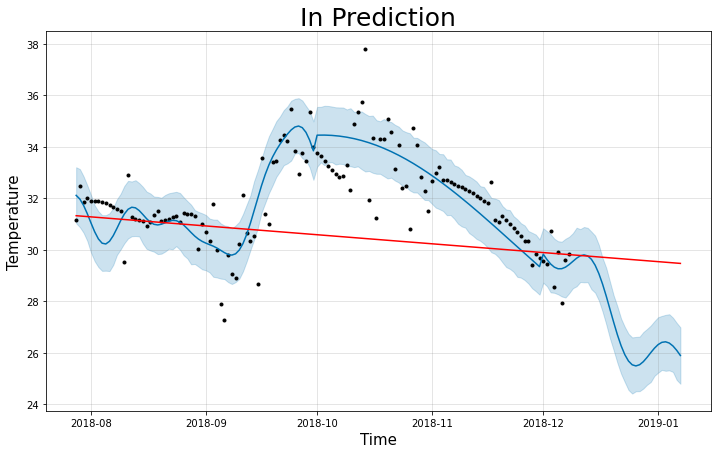

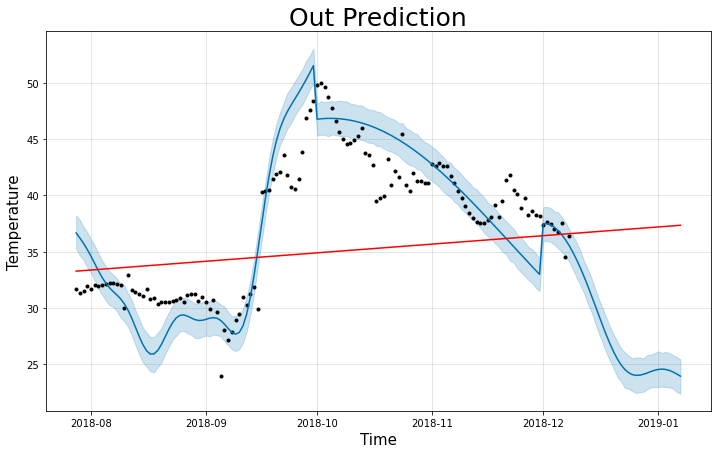

In [42]:
run_prophet('In',30, False)
run_prophet('Out',30, False)